## Data Preprocessing for chicago crime data

Load the data, and choose data only after 2018 (2017 for crime rate change inference)

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import warnings
import importlib

data_path = "./data/"
model_path = "./model/"
figure_path = "./figure/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

## Download Required Dataset


In [ ]:
def extract_zip(zip_path, extract_to):
    if os.path.exists(os.path.join(extract_to, ".extraction_complete")):
        print(f"Files already extracted to {extract_to}")
        return True
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        with open(os.path.join(extract_to, ".extraction_complete"), "w") as f:
            f.write("Extraction completed")
        print(f"Successfully extracted files to {extract_to}")
        return True
    except Exception as e:
        print(f"Error during extraction: {e}")
        return False
def download_from_gdrive(file_id, output_file):
    if os.path.exists(output_file):
        print(f"File already exists: {output_file}")
        return True
    try:
        if importlib.util.find_spec("gdown") is None:
            print("Installing gdown...")
            !pip install gdown
        import gdown
        gdown.download(id=file_id, output=output_file, quiet=False, use_cookies=False)
        print(f"Successfully downloaded {output_file}")
        return True
    except Exception as e:
        print(f"Error downloading file: {e}")
        return False
download_from_gdrive('1UPypcqtB8p48p0ZWaxrslDXEKQSmrNul', f'{data_path}chicago_crime.csv')
download_from_gdrive('1RrdhiIXINviz-ZlX1hzgQnXBAJoUobFL', f'{data_path}AL.zip')
extract_zip("./data/AL.zip", "./data/AL")
#This may take a while (Chicago Crime ~30 seconds, FBI_AL.zip ~ 1 second)

In [5]:
df = pd.read_csv(f"{data_path}chicago_crime.csv")

In [6]:
# Choose designated time range and check for missing values.
df["Date"] = pd.to_datetime(df["Date"])
df_after = df[
    (
        df["Date"].dt.year.isin([2018, 2019, 2020, 2021, 2022, 2023, 2024])
        | (df["Date"].dt.month == 12) & (df["Date"].dt.year == 2017)
    )
]
df_after.isnull().sum()

ID                          0
Case Number                 0
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     8962
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       52
Community Area              4
FBI Code                    0
X Coordinate            26318
Y Coordinate            26318
Year                        0
Updated On                  0
Latitude                26318
Longitude               26318
Location                26318
dtype: int64

Timestamp & temporal event Featurization

In [7]:
# Infer timestamp and temporal feature like year, month, weekday from "Date" 
df_clean = df_after.copy()
df_clean = df_clean.sort_values(by="Date")
df_clean["Date"] = pd.to_datetime(df_clean["Date"], format="%Y-%m-%dT%H:%M:%S.%f")
df_clean["Year"] = df_clean["Date"].dt.year
df_clean["Month"] = df_clean["Date"].dt.month
df_clean["Day"] = df_clean["Date"].dt.day
df_clean["Hour"] = df_clean["Date"].dt.hour
df_clean["WeekDay"] = df_clean["Date"].dt.weekday
df_clean["IsWeekDay"] = (df_clean["WeekDay"] < 5).astype(bool)
df_clean["Isweekend"] = (df_clean["WeekDay"] >= 5).astype(bool)
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ["Night", "Morning", "Afternoon", "Evening"]
season_bins = [0, 3, 6, 9, 12]
season_labels = ["Winter", "Spring", "Summer", "Fall"]
df_clean["TimeCategory"] = pd.cut(
    df_clean["Hour"], bins=hour_bins, labels=hour_labels, include_lowest=True
)
time_dummies = pd.get_dummies(df_clean["TimeCategory"])
df_clean = pd.concat([df_clean, time_dummies], axis=1)
df_clean["Season"] = pd.cut(
    df_clean["Month"], bins=season_bins, labels=season_labels, include_lowest=True
)
# Drop unnecessary columns
df_clean.drop(
    columns=[
        "Community Area",
        "Ward",
        "X Coordinate",
        "Y Coordinate",
        "Latitude",
        "Longitude",
        "Location",
    ],
    inplace=True,
)
df_clean.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description    8962
Arrest                     0
Domestic                   0
Beat                       0
District                   1
FBI Code                   0
Year                       0
Updated On                 0
Month                      0
Day                        0
Hour                       0
WeekDay                    0
IsWeekDay                  0
Isweekend                  0
TimeCategory               0
Night                      0
Morning                    0
Afternoon                  0
Evening                    0
Season                     0
dtype: int64

Standardize location categories from NIBRS location type list

In [8]:
# Dictionary of  standard location id and name in NIBRS location type.

standard_locations = {
    1: "Abandoned/Condemned Structure",
    2: "Air/Bus/Train Terminal",
    3: "Amusement Park",
    4: "Arena/Stadium/Fairgrounds/Coliseum",
    5: "ATM Separate from Bank",
    6: "Auto Dealership New/Used",
    7: "Bank/Savings and Loan",
    8: "Bar/Nightclub",
    9: "Camp/Campground",
    10: "Church/Synagogue/Temple/Mosque",
    11: "Commercial/Office Building",
    12: "Community Center",
    13: "Construction Site",
    14: "Convenience Store",
    15: "Cyberspace",
    16: "Daycare Facility",
    17: "Department/Discount Store",
    18: "Dock/Wharf/Freight/Modal Terminal",
    19: "Drug Store/Doctor's Office/Hospital",
    20: "Farm Facility",
    21: "Field/Woods",
    22: "Gambling Facility/Casino/Race Track",
    23: "Government/Public Building",
    24: "Grocery/Supermarket",
    25: "Highway/Road/Alley/Street/Sidewalk",
    26: "Hotel/Motel/Etc.",
    27: "Industrial Site",
    28: "Jail/Prison/Penitentiary/Corrections Facility",
    29: "Lake/Waterway/Beach",
    30: "Liquor Store",
    31: "Military Installation",
    32: "Park/Playground",
    33: "Parking/Drop Lot/Garage",
    34: "Rental Storage Facility",
    35: "Residence/Home",
    36: "Rest Area",
    37: "Restaurant",
    38: "School/College",
    39: "School-College/University",
    40: "School-Elementary/Secondary",
    41: "Service/Gas Station",
    42: "Shelter-Mission/Homeless",
    43: "Shopping Mall",
    44: "Specialty Store",
    45: "Tribal Lands",
    98: "Other/Unknown",
    99: "Not Specified",
}
inverse_mapping = {v: k for k, v in standard_locations.items()}

# Map from Chicago dataset's location descriptions to the standard categories.

chicago_to_standard = {
    "RESIDENCE": standard_locations[35],
    "SIDEWALK": standard_locations[25],
    "PARKING LOT / GARAGE (NON RESIDENTIAL)": standard_locations[33],
    "BANK": standard_locations[7],
    "OTHER (SPECIFY)": standard_locations[98],
    "RESIDENCE - PORCH / HALLWAY": standard_locations[35],
    "STREET": standard_locations[25],
    "RESIDENCE - GARAGE": standard_locations[35],
    "ALLEY": standard_locations[25],
    "APARTMENT": standard_locations[35],
    "AUTO / BOAT / RV DEALERSHIP": standard_locations[6],
    "POLICE FACILITY / VEHICLE PARKING LOT": standard_locations[33],
    "DEPARTMENT STORE": standard_locations[17],
    "CHA PARKING LOT / GROUNDS": standard_locations[33],
    "RESTAURANT": standard_locations[37],
    "GROCERY FOOD STORE": standard_locations[24],
    "APPLIANCE STORE": standard_locations[98],
    "SMALL RETAIL STORE": standard_locations[98],
    # Use "Not Specified" for missing values:
    np.nan: standard_locations[99],
    "CAR WASH": standard_locations[98],
    "VEHICLE NON-COMMERCIAL": standard_locations[98],
    "CTA BUS": standard_locations[2],
    "COMMERCIAL / BUSINESS OFFICE": standard_locations[11],
    "PARK PROPERTY": standard_locations[32],
    "DRUG STORE": standard_locations[19],
    "RESIDENCE - YARD (FRONT / BACK)": standard_locations[35],
    "BAR OR TAVERN": standard_locations[8],
    "LAKEFRONT / WATERFRONT / RIVERBANK": standard_locations[29],
    "SCHOOL - PUBLIC BUILDING": standard_locations[38],
    "AIRPORT TERMINAL LOWER LEVEL - SECURE AREA": standard_locations[2],
    "NURSING / RETIREMENT HOME": standard_locations[98],
    "HOTEL / MOTEL": standard_locations[26],
    "CONVENIENCE STORE": standard_locations[14],
    "GAS STATION": standard_locations[41],
    "CTA BUS STOP": standard_locations[2],
    "AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA": standard_locations[2],
    "GOVERNMENT BUILDING / PROPERTY": standard_locations[23],
    "TAVERN / LIQUOR STORE": standard_locations[8],
    "CTA PLATFORM": standard_locations[2],
    "COLLEGE / UNIVERSITY - RESIDENCE HALL": standard_locations[35],
    "AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA": standard_locations[2],
    "HOSPITAL BUILDING / GROUNDS": standard_locations[19],
    "VEHICLE - COMMERCIAL": standard_locations[98],
    "SCHOOL - PUBLIC GROUNDS": standard_locations[38],
    "WAREHOUSE": standard_locations[11],
    "CTA TRAIN": standard_locations[2],
    "ATM (AUTOMATIC TELLER MACHINE)": standard_locations[5],
    "AIRPORT TERMINAL UPPER LEVEL - SECURE AREA": standard_locations[2],
    "CONSTRUCTION SITE": standard_locations[13],
    "AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA": standard_locations[2],
    "ATHLETIC CLUB": standard_locations[98],
    "CHURCH / SYNAGOGUE / PLACE OF WORSHIP": standard_locations[10],
    "CURRENCY EXCHANGE": standard_locations[7],
    "CTA STATION": standard_locations[2],
    "CEMETARY": standard_locations[98],
    "ABANDONED BUILDING": standard_locations[1],
    "VACANT LOT / LAND": standard_locations[25],
    "CHA HALLWAY / STAIRWELL / ELEVATOR": standard_locations[35],
    "DRIVEWAY - RESIDENTIAL": standard_locations[35],
    "RETAIL STORE": standard_locations[98],
    "CHA APARTMENT": standard_locations[35],
    "SCHOOL - PRIVATE GROUNDS": standard_locations[38],
    "LIBRARY": standard_locations[23],
    "CTA TRACKS - RIGHT OF WAY": standard_locations[2],
    "GAS STATION DRIVE/PROP.": standard_locations[41],
    "BARBERSHOP": standard_locations[98],
    "BOAT / WATERCRAFT": standard_locations[98],
    "ANIMAL HOSPITAL": standard_locations[98],
    "TAXICAB": standard_locations[98],
    "SCHOOL - PRIVATE BUILDING": standard_locations[38],
    "MEDICAL / DENTAL OFFICE": standard_locations[19],
    "SPORTS ARENA / STADIUM": standard_locations[4],
    "OTHER COMMERCIAL TRANSPORTATION": standard_locations[98],
    "AIRCRAFT": standard_locations[98],
    "AIRPORT PARKING LOT": standard_locations[33],
    "VEHICLE - DELIVERY TRUCK": standard_locations[98],
    "MOVIE HOUSE / THEATER": standard_locations[4],
    "CTA PARKING LOT / GARAGE / OTHER PROPERTY": standard_locations[33],
    "DAY CARE CENTER": standard_locations[16],
    "PORCH": standard_locations[35],
    "FACTORY / MANUFACTURING BUILDING": standard_locations[27],
    "OTHER RAILROAD PROPERTY / TRAIN DEPOT": standard_locations[2],
    "HIGHWAY / EXPRESSWAY": standard_locations[25],
    "FEDERAL BUILDING": standard_locations[23],
    "HOUSE": standard_locations[35],
    "PAWN SHOP": standard_locations[98],
    "CREDIT UNION": standard_locations[7],
    "OTHER": standard_locations[98],
    "COLLEGE / UNIVERSITY - GROUNDS": standard_locations[38],
    "CASINO/GAMBLING ESTABLISHMENT": standard_locations[22],
    "PARKING LOT": standard_locations[33],
    "VACANT LOT": standard_locations[25],
    "HALLWAY": standard_locations[35],
    "VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)": standard_locations[98],
    "VESTIBULE": standard_locations[35],
    "AIRPORT EXTERIOR - SECURE AREA": standard_locations[2],
    "AUTO": standard_locations[6],
    "COIN OPERATED MACHINE": standard_locations[98],
    "CLEANING STORE": standard_locations[98],
    "AIRPORT TRANSPORTATION SYSTEM (ATS)": standard_locations[2],
    "JAIL / LOCK-UP FACILITY": standard_locations[28],
    "HOSPITAL BUILDING/GROUNDS": standard_locations[19],
    "RESIDENCE PORCH/HALLWAY": standard_locations[35],
    "BRIDGE": standard_locations[25],
    "AIRPORT EXTERIOR - NON-SECURE AREA": standard_locations[2],
    "HOTEL/MOTEL": standard_locations[26],
    "AIRPORT VENDING ESTABLISHMENT": standard_locations[98],
    "AIRPORT/AIRCRAFT": standard_locations[2],
    "GARAGE": standard_locations[33],
    'CTA "L" TRAIN': standard_locations[2],
    "KENNEL": standard_locations[98],
    "FOREST PRESERVE": standard_locations[98],
    "BOWLING ALLEY": standard_locations[98],
    "FIRE STATION": standard_locations[23],
    "YARD": standard_locations[35],
    "VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS": standard_locations[98],
    "AIRPORT BUILDING NON-TERMINAL - SECURE AREA": standard_locations[2],
    "GANGWAY": standard_locations[98],
    "HOSPITAL": standard_locations[19],
    "SAVINGS AND LOAN": standard_locations[7],
    "AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA": standard_locations[2],
    "SCHOOL YARD": standard_locations[38],
    "CHA HALLWAY": standard_locations[35],
    "PARKING LOT/GARAGE(NON.RESID.)": standard_locations[33],
    "GOVERNMENT BUILDING/PROPERTY": standard_locations[23],
    "DRIVEWAY": standard_locations[35],
    "HOTEL": standard_locations[26],
    "RESIDENTIAL YARD (FRONT/BACK)": standard_locations[35],
    "LIQUOR STORE": standard_locations[30],
    "VEHICLE - COMMERCIAL: TROLLEY BUS": standard_locations[98],
    "CTA SUBWAY STATION": standard_locations[2],
    "BEACH": standard_locations[29],
    "STAIRWELL": standard_locations[35],
    "TAVERN": standard_locations[8],
    "OFFICE": standard_locations[11],
    "CHA GROUNDS": standard_locations[35],
    "CTA PROPERTY": standard_locations[2],
    "SCHOOL, PUBLIC, BUILDING": standard_locations[38],
    "POLICE FACILITY/VEH PARKING LOT": standard_locations[33],
    "MEDICAL/DENTAL OFFICE": standard_locations[19],
    "OTHER RAILROAD PROP / TRAIN DEPOT": standard_locations[2],
    "SPORTS ARENA/STADIUM": standard_locations[4],
    "SCHOOL, PRIVATE, BUILDING": standard_locations[38],
    "NURSING HOME/RETIREMENT HOME": standard_locations[98],
    "CHA HALLWAY/STAIRWELL/ELEVATOR": standard_locations[35],
    "CHA PARKING LOT": standard_locations[33],
    "WOODED AREA": standard_locations[98],
    "YMCA": standard_locations[98],
    "GARAGE/AUTO REPAIR": standard_locations[33],
    "BANQUET HALL": standard_locations[98],
    "BARBER SHOP/BEAUTY SALON": standard_locations[98],
    "CHA STAIRWELL": standard_locations[35],
    "MOTEL": standard_locations[26],
    'CTA "L" PLATFORM': standard_locations[2],
    "CHA ELEVATOR": standard_locations[35],
    "BASEMENT": standard_locations[35],
    "ROOF": standard_locations[35],
    "NURSING HOME": standard_locations[98],
    "CLUB": standard_locations[8],
    "CHA LOBBY": standard_locations[35],
    "RIVER BANK": standard_locations[29],
    "CHA PLAY LOT": standard_locations[35],
    "ELEVATOR": standard_locations[35],
    "RAILROAD PROPERTY": standard_locations[2],
    "TRAILER": standard_locations[35],
    "POLICE FACILITY": standard_locations[23],
    "GOVERNMENT BUILDING": standard_locations[23],
    "LAKE": standard_locations[29],
    "TRUCK": standard_locations[98],
    "PUBLIC GRAMMAR SCHOOL": standard_locations[38],
    "SCHOOL, PUBLIC, GROUNDS": standard_locations[38],
    "CHA PARKING LOT/GROUNDS": standard_locations[33],
    "RESIDENCE-GARAGE": standard_locations[35],
    "MOVIE HOUSE/THEATER": standard_locations[4],
    "CHURCH/SYNAGUE/PLACE OF WORSHIP": standard_locations[10],
    "TAVERN/LIQUOR STORE": standard_locations[8],
    "VACANT LOT/LAND": standard_locations[25],
    "CTA GARAGE / OTHER PROPERTY": standard_locations[2],
    "VEHICLE-COMMERCIAL": standard_locations[98],
    "COLLEGE/UNIVERSITY GROUNDS": standard_locations[38],
    "VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)": standard_locations[98],
    "VEHICLE-COMMERCIAL - TROLLEY BUS": standard_locations[98],
    "SCHOOL, PRIVATE, GROUNDS": standard_locations[38],
    "FACTORY/MANUFACTURING BUILDING": standard_locations[27],
    "COLLEGE/UNIVERSITY RESIDENCE HALL": standard_locations[35],
    "HIGHWAY/EXPRESSWAY": standard_locations[25],
    "POOL ROOM": standard_locations[98],
    "NEWSSTAND": standard_locations[98],
    "LAKEFRONT/WATERFRONT/RIVERBANK": standard_locations[29],
    "VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS": standard_locations[98],
    "BOAT/WATERCRAFT": standard_locations[98],
    "FARM": standard_locations[20],
    "HORSE STABLE": standard_locations[98],
}


def map_location(desc):
    if pd.isnull(desc):
        return standard_locations[99]
    return chicago_to_standard.get(desc, standard_locations[98])


df_clean["location_name"] = df_clean["Location Description"].apply(map_location)
df_clean["location_id"] = df_clean["location_name"].apply(lambda x: inverse_mapping[x])
df_clean[["location_name", "location_id"]].head(10)

,location_name,location_id
6723233,Highway/Road/Alley/Street/Sidewalk,25
112206,Highway/Road/Alley/Street/Sidewalk,25
6556926,Bank/Savings and Loan,7
6806706,Residence/Home,35
6692997,Residence/Home,35
6752046,Residence/Home,35
7421033,Residence/Home,35
6651763,Other/Unknown,98
6612435,Residence/Home,35
7912375,Other/Unknown,98


In [9]:
# Binary flag features from holiday information
cal = USFederalHolidayCalendar()

start_date = df_clean["Date"].min()
end_date = df_clean["Date"].max()

# Get holidays in dataset timeframe
holidays = cal.holidays(start=start_date, end=end_date)

# Check if each date is a holiday
df_clean["IsHoliday"] = df_clean["Date"].dt.date.isin(holidays.date).astype(int)
df_clean["FBI Code"].unique()

array(['20', '26', '11', '17', '12', '08B', '06', '02', '14', '04B', '07',
       '05', '03', '04A', '08A', '18', '10', '24', '22', '15', '19',
       '01A', '16', '13', '09', '01B', '27'], dtype=object)

In [10]:
# Dataset condition after clean

df_analysis = pd.DataFrame(
    {
        "Column": df_clean.columns,
        "Unique Values": df_clean.nunique().values,
        "Type": df_clean.dtypes.values,
        "Is Null": df_clean.isnull().sum().values,
    }
)
df_analysis.sort_values("Unique Values", ascending=False)

,Column,Unique Values,Type,Is Null
0,ID,1733685,int64,0
1,Case Number,1733477,object,0
2,Date,840699,datetime64[ns],0
3,Block,37834,object,0
14,Updated On,5067,object,0
6,Description,515,object,0
4,IUCR,377,object,0
10,Beat,275,int64,0
7,Location Description,193,object,8962
5,Primary Type,34,object,0


#### Time-series Dataset Processing


Temporal Aggregation and Normalization

In [11]:
# Aggregation of temporal data
df_time = df_clean.copy()
df_time["crime_count"] = 1
holiday_calendar = (
    df_time[df_time["IsHoliday"] == 1]
    .drop_duplicates(subset=["Year", "Month", "Day"])  # count each holiday once per day
    .groupby(["Year", "Month"], as_index=False)
    .agg(holiday_num=("Day", "count"))
)
df_time = df_time.groupby(
    [
        "location_name",
        "location_id",
        "Year",
        "Month",
    ],
    as_index=False,
    observed=False,
).agg(
    crime_count=("crime_count", "sum"),
    arrest=("Arrest", "sum"),
    domestic=("Domestic", "sum"),
    # holiday=("IsHoliday", "sum"),
    weekday=("IsWeekDay", "sum"),
    weekend=("Isweekend", "sum"),
    morning=("Morning", "sum"),
    afternoon=("Afternoon", "sum"),
    evening=("Evening", "sum"),
    night=("Night", "sum"),
)
df_time = pd.merge(df_time, holiday_calendar, on=["Year", "Month"], how="left")
# Count holidays and days by each month
df_time["holiday_num"] = df_time["holiday_num"].fillna(0).astype(int)
df_time["num_days"] = df_time.apply(
    lambda row: calendar.monthrange(row["Year"], row["Month"])[1], axis=1
)
# Feature normalization for features in list
ls_features = [
    "arrest",
    "domestic",
    "morning",
    "afternoon",
    "evening",
    "night",
    # "holiday",
    # "weekday",
    # "weekend",
]

for feature in ls_features:
    df_time[f"{feature}_rate"] = df_time[feature] / df_time["crime_count"]

# Apply sine/cosine transformation to month 
df_time["sin_month"] = np.sin(2 * np.pi * (df_time["Month"] - 1) / 12)
df_time["cos_month"] = np.cos(2 * np.pi * (df_time["Month"] - 1) / 12)
# Create a unique time ID for chronological tracking and lag feature generation
df_time["time_id"] = df_time["Year"] * 12 + df_time["Month"]

In [12]:
# Attributes after aggregation and normalization

df_time.columns

Index(['location_name', 'location_id', 'Year', 'Month', 'crime_count',
       'arrest', 'domestic', 'weekday', 'weekend', 'morning', 'afternoon',
       'evening', 'night', 'holiday_num', 'num_days', 'arrest_rate',
       'domestic_rate', 'morning_rate', 'afternoon_rate', 'evening_rate',
       'night_rate', 'sin_month', 'cos_month', 'time_id'],
      dtype='object')

Feature importance analysis

Recommended features to keep:
- domestic_rate
- location_id
- evening_rate
- night_rate
- num_days
- holiday_num
- sin_month


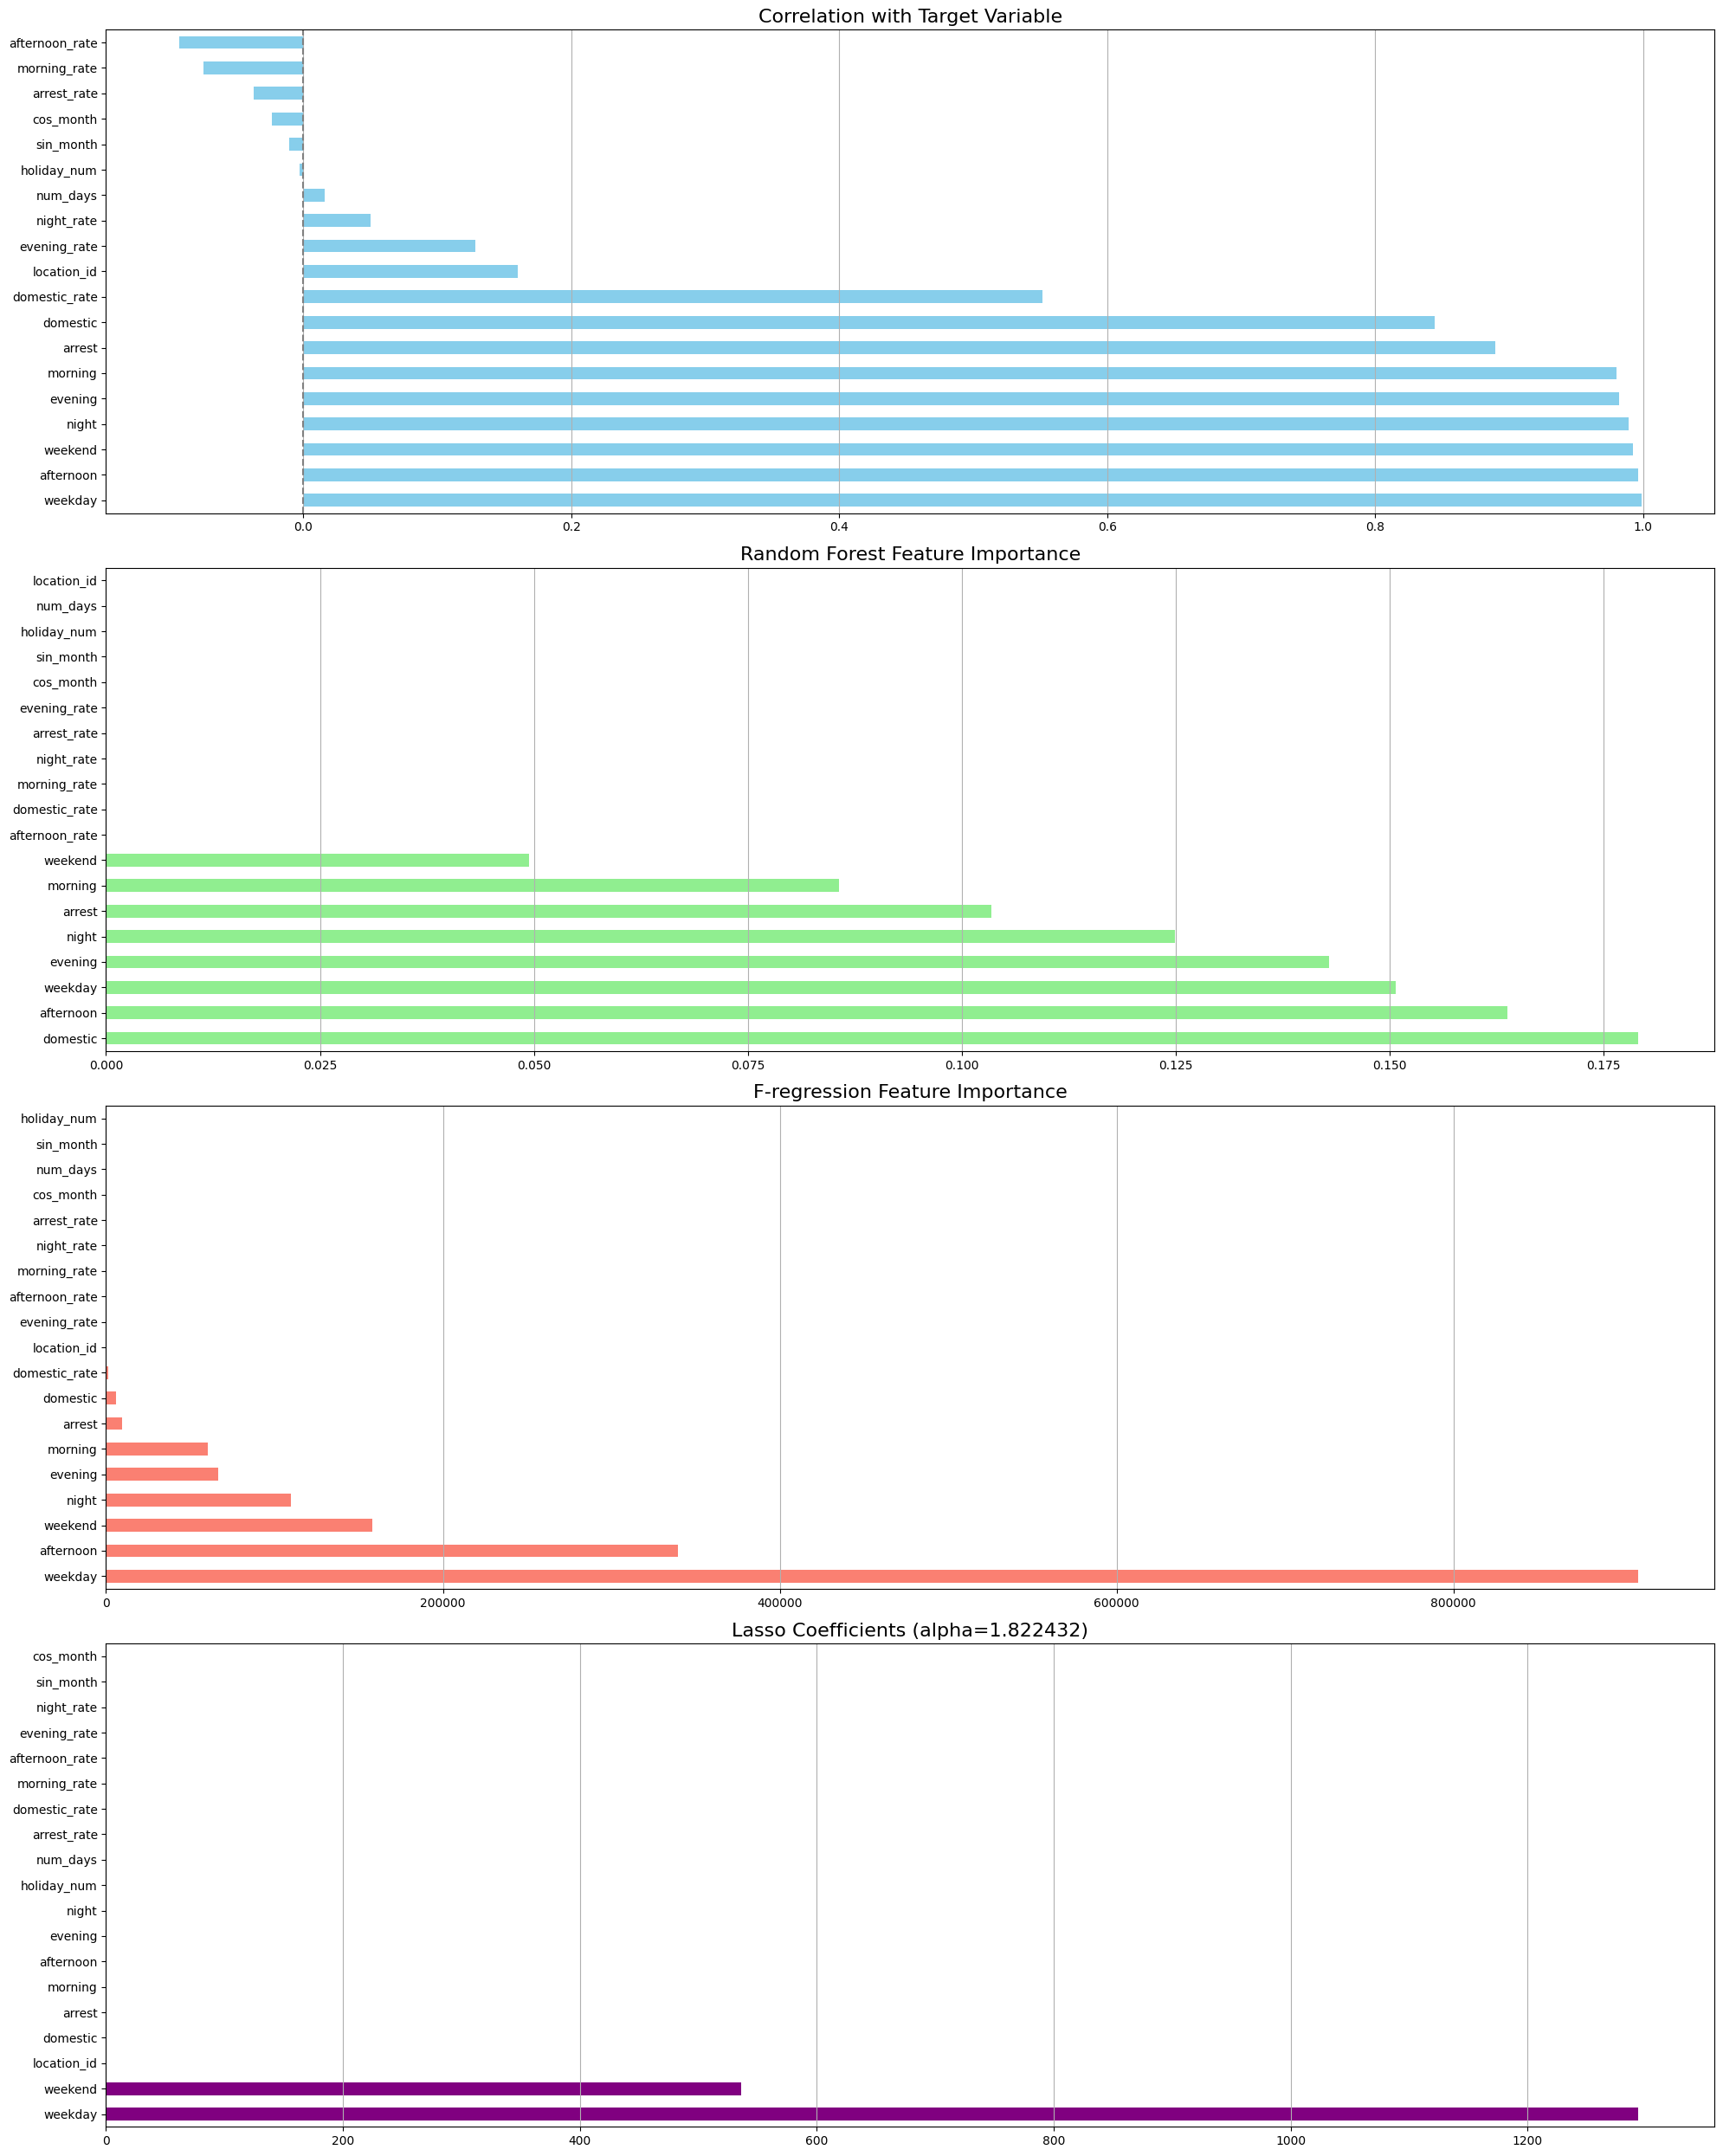

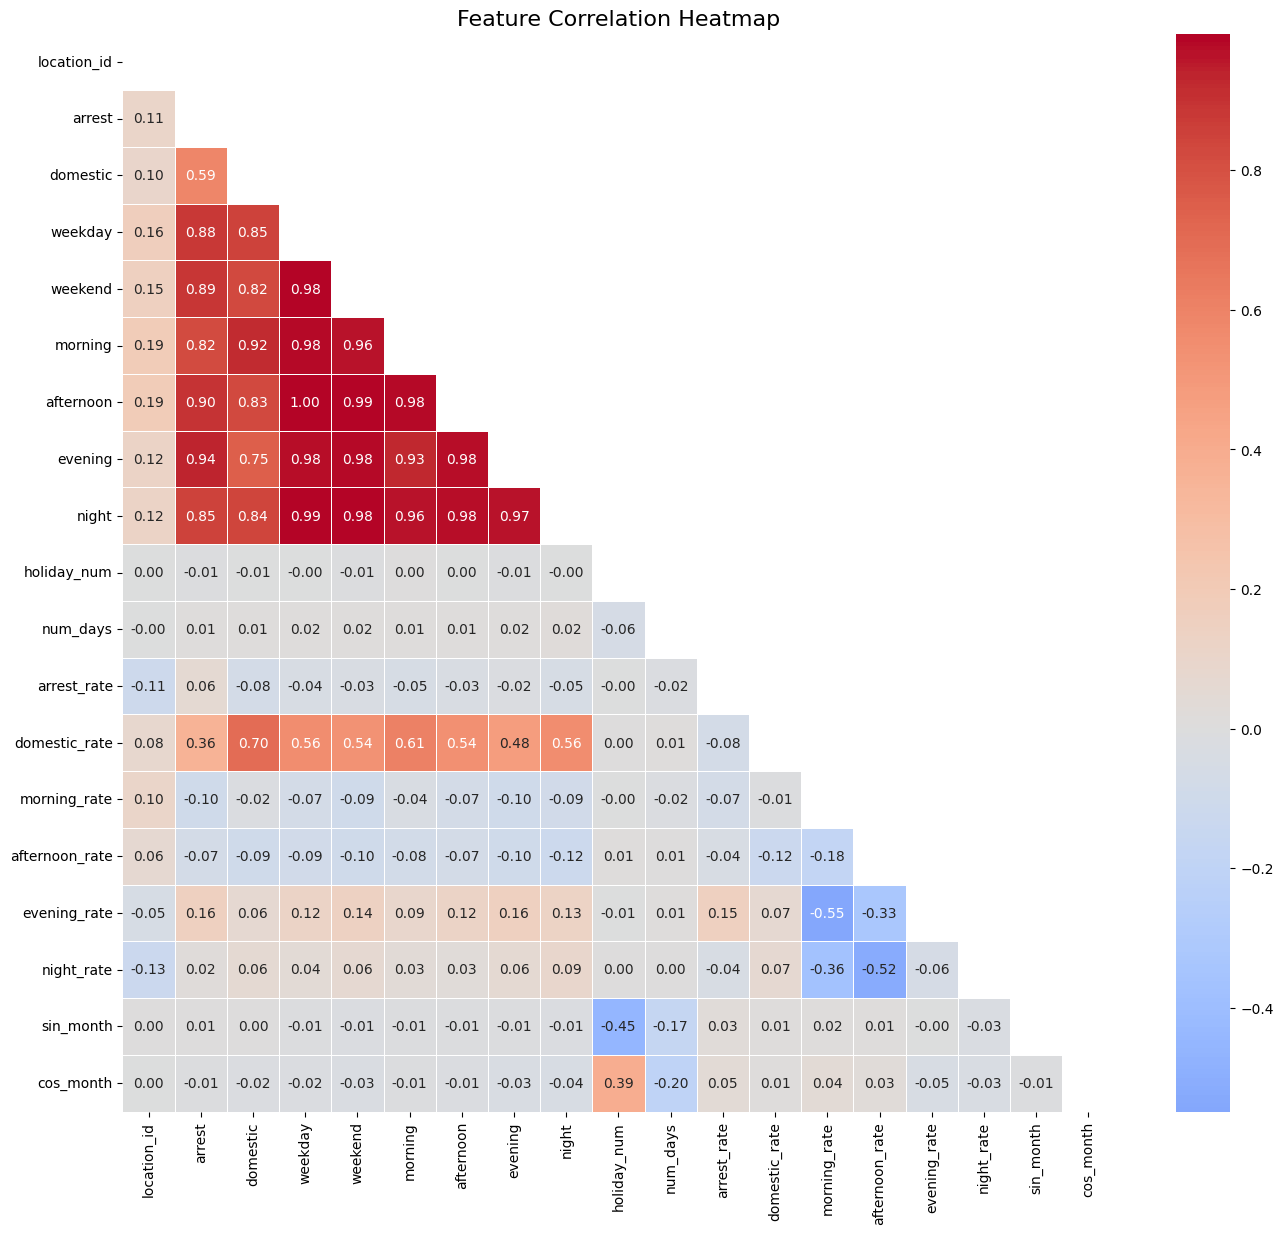

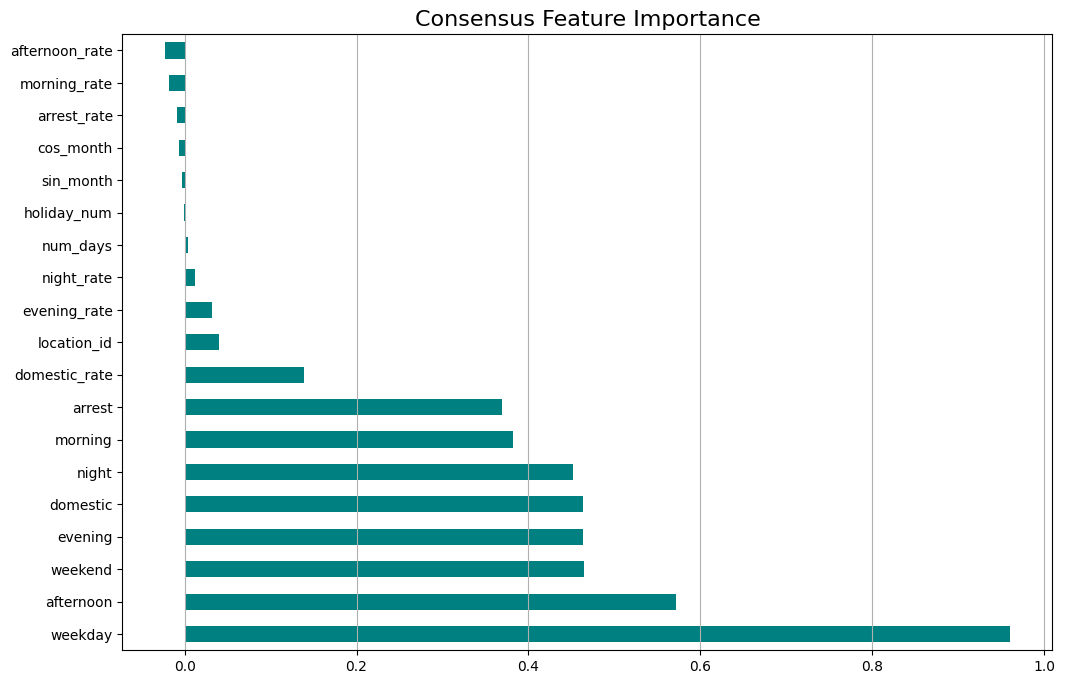

In [13]:
warnings.filterwarnings("ignore")
def analyze_feature_importance(df, target_column="crime_count", exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Ensure target_column is not in exclude_columns
    if target_column in exclude_columns:
        exclude_columns.remove(target_column)

    # Add target_column to exclude_columns for feature extraction
    features_exclude = exclude_columns + [target_column]

    # Prepare data
    y = df[target_column].values
    X = df.drop(columns=features_exclude)
    feature_names = X.columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

    # 1. Correlation with target
    correlations = (
        df[feature_names + [target_column]]
        .corr()[target_column]
        .drop(target_column)
        .sort_values(ascending=False)
    )

    # 2. Multicollinearity check
    correlation_matrix = df[feature_names].corr()

    # 3. Feature importance from Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    rf_importances = pd.Series(
        rf.feature_importances_, index=feature_names
    ).sort_values(ascending=False)

    # 4. F-regression for linear relationships
    f_selector = SelectKBest(f_regression, k="all")
    f_selector.fit(X_scaled, y)
    f_scores = pd.Series(f_selector.scores_, index=feature_names).sort_values(
        ascending=False
    )

    # 5. Lasso regularization for feature selection
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, y)
    alpha = lasso_cv.alpha_

    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs = pd.Series(np.abs(lasso.coef_), index=feature_names).sort_values(
        ascending=False
    )

    # Create visualizations
    plt.figure(figsize=(20, 25))

    # 1. Correlation with target
    plt.subplot(4, 1, 1)
    correlations.plot(kind="barh", color="skyblue")
    plt.title("Correlation with Target Variable", fontsize=16)
    plt.axvline(x=0, color="gray", linestyle="--")
    plt.grid(axis="x")

    # 2. Random Forest Feature Importance
    plt.subplot(4, 1, 2)
    rf_importances.plot(kind="barh", color="lightgreen")
    plt.title("Random Forest Feature Importance", fontsize=16)
    plt.grid(axis="x")

    # 3. F-regression scores
    plt.subplot(4, 1, 3)
    f_scores.plot(kind="barh", color="salmon")
    plt.title("F-regression Feature Importance", fontsize=16)
    plt.grid(axis="x")

    # 4. Lasso Coefficients
    plt.subplot(4, 1, 4)
    lasso_coefs.plot(kind="barh", color="purple")
    plt.title(f"Lasso Coefficients (alpha={alpha:.6f})", fontsize=16)
    plt.grid(axis="x")

    plt.tight_layout()

    # Correlation heatmap in a separate figure
    plt.figure(figsize=(16, 14))
    mask = np.triu(correlation_matrix)
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        center=0,
        mask=mask,
        fmt=".2f",
        linewidths=0.5,
    )
    plt.title("Feature Correlation Heatmap", fontsize=16)

    # Create a consensus ranking
    results = pd.DataFrame(
        {
            "Correlation": correlations,
            "RandomForest": rf_importances,
            "F_Score": f_scores,
            "Lasso": lasso_coefs,
        }
    )

    # Normalize each column to range 0-1
    normalized_results = results.copy()
    for col in normalized_results.columns:
        if normalized_results[col].max() > 0:
            normalized_results[col] = (
                normalized_results[col] / normalized_results[col].max()
            )

    # Calculate consensus score (average of normalized scores)
    normalized_results["Consensus_Score"] = normalized_results.mean(axis=1)
    normalized_results = normalized_results.sort_values(
        "Consensus_Score", ascending=False
    )

    # Visualize consensus ranking
    plt.figure(figsize=(12, 8))
    normalized_results["Consensus_Score"].plot(kind="barh", color="teal")
    plt.title("Consensus Feature Importance", fontsize=16)
    plt.grid(axis="x")

    return {
        "correlations": correlations,
        "rf_importances": rf_importances,
        "f_scores": f_scores,
        "lasso_coefs": lasso_coefs,
        "correlation_matrix": correlation_matrix,
        "consensus_ranking": normalized_results,
        "lasso_alpha": alpha,
    }


def suggest_features_to_keep(results, correlation_threshold=0.7, top_n=15):
    top_features = results["consensus_ranking"].index[:top_n].tolist()
    corr_matrix = results["correlation_matrix"].loc[top_features, top_features]
    high_corr_pairs = []
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            corr = abs(corr_matrix.iloc[i, j])
            if corr > correlation_threshold:
                high_corr_pairs.append((top_features[i], top_features[j], corr))

    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

    to_remove = set()
    for feat1, feat2, corr in high_corr_pairs:
        score1 = results["consensus_ranking"].loc[feat1, "Consensus_Score"]
        score2 = results["consensus_ranking"].loc[feat2, "Consensus_Score"]

        if score1 >= score2 and feat2 not in to_remove:
            to_remove.add(feat2)
        elif feat1 not in to_remove:
            to_remove.add(feat1)

    features_to_keep = [f for f in top_features if f not in to_remove]

    lasso_zeros = results["lasso_coefs"][results["lasso_coefs"] < 0.001].index.tolist()

    return {
        "recommended_features": features_to_keep,
        "high_correlation_pairs": high_corr_pairs,
        "features_to_remove": list(to_remove),
        "lasso_eliminated": lasso_zeros,
        "top_by_method": {
            "correlation": results["correlations"].index[:5].tolist(),
            "random_forest": results["rf_importances"].index[:5].tolist(),
            "f_score": results["f_scores"].index[:5].tolist(),
            "lasso": results["lasso_coefs"].index[:5].tolist(),
        },
    }


exclude_cols = [
    "location_name",
    "Year",
    "Month",
    "time_id",
]  # columns to exclude from feature importance analysis
results = analyze_feature_importance(
    df_time, target_column="crime_count", exclude_columns=exclude_cols
)
suggestions = suggest_features_to_keep(results, correlation_threshold=0.7, top_n=15)

print("Recommended features to keep:")
for feature in suggestions["recommended_features"]:
    print(f"- {feature}")

In [14]:
df_time = df_time.sort_values(["location_id", "Year", "Month"])

Lagged Values Computation

In [15]:
# Calculation crime rate change over months

df_pct = df_time.copy()
df_pct["crime_pct_change"] = df_pct["crime_count"].pct_change()
df_pct = df_pct[df_pct["Year"] >= 2018]
df_pct.to_csv(f"{data_path}rnn_data.csv", index=False)
df_pct.sort_values(["Year", "Month", "location_name"])

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,arrest_rate,domestic_rate,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change
1,ATM Separate from Bank,5,2018,1,49,0,0,33,16,15,...,0.000000,0.000000,0.306122,0.183673,0.142857,0.367347,0.0,1.000000,24217,-0.309859
86,Abandoned/Condemned Structure,1,2018,1,20,7,1,15,5,8,...,0.350000,0.050000,0.400000,0.300000,0.200000,0.100000,0.0,1.000000,24217,-0.166667
171,Air/Bus/Train Terminal,2,2018,1,518,128,16,414,104,106,...,0.247104,0.030888,0.204633,0.434363,0.206564,0.154440,0.0,1.000000,24217,0.095137
256,Arena/Stadium/Fairgrounds/Coliseum,4,2018,1,18,3,2,15,3,0,...,0.166667,0.111111,0.000000,0.500000,0.444444,0.055556,0.0,1.000000,24217,-0.400000
341,Auto Dealership New/Used,6,2018,1,20,1,2,15,5,3,...,0.050000,0.100000,0.150000,0.200000,0.350000,0.300000,0.0,1.000000,24217,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,Parking/Drop Lot/Garage,33,2024,12,757,99,44,539,218,190,...,0.130779,0.058124,0.250991,0.328930,0.239102,0.180978,-0.5,0.866025,24300,0.014745
2206,Residence/Home,35,2024,12,7369,681,3087,5202,2167,1904,...,0.092414,0.418917,0.258380,0.298819,0.208305,0.234496,-0.5,0.866025,24300,0.058308
2291,Restaurant,37,2024,12,494,39,14,320,174,73,...,0.078947,0.028340,0.147773,0.421053,0.210526,0.220648,-0.5,0.866025,24300,-0.078358
2376,School/College,38,2024,12,253,17,13,248,5,121,...,0.067194,0.051383,0.478261,0.418972,0.031621,0.071146,-0.5,0.866025,24300,-0.109155


In [16]:
df_lag = df_pct.copy()
for location_group, location_df in df_lag.groupby(["location_name"]):
    # Get indices for this location group
    indices = location_df.index

    # Get time-ordered data
    temp_df = df_lag.loc[indices].sort_values("time_id")
    all_features = [
        "crime_pct_change",
        "domestic_rate",
        "arrest_rate",
        # "holiday_rate",
        "morning_rate",
        "afternoon_rate",
        "evening_rate",
        "night_rate",
        "crime_count",
        "domestic",
        "arrest",
        "morning",
        "afternoon",
        "evening",
        "night",
    ]
    # Add lagged features
    for lag in [1, 2, 3, 6, 12]:
        for feature in all_features:
            df_lag.loc[indices, f"{feature}_lag{lag}"] = temp_df[feature].shift(lag)
    # Create lagged moving average features
    for lag in [3, 6]:
        for feature in all_features:
            df_lag.loc[indices, f"{feature}_ma{lag}"] = (
                temp_df[feature].rolling(window=lag).mean().shift(1)
            )

df_lag = df_lag.dropna()
df_lag.sort_values(["Year", "Month", "location_id"], inplace=True)
df_lag

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,afternoon_rate_ma6,evening_rate_ma6,night_rate_ma6,crime_count_ma6,domestic_ma6,arrest_ma6,morning_ma6,afternoon_ma6,evening_ma6,night_ma6
98,Abandoned/Condemned Structure,1,2019,1,27,15,0,24,3,16,...,0.370560,0.181767,0.147859,25.333333,1.500000,11.833333,7.500000,9.666667,4.333333,3.833333
183,Air/Bus/Train Terminal,2,2019,1,615,148,11,482,133,125,...,0.416996,0.192180,0.166426,650.500000,15.000000,120.166667,145.666667,270.833333,125.333333,108.666667
268,Arena/Stadium/Fairgrounds/Coliseum,4,2019,1,30,3,0,19,11,5,...,0.352853,0.414232,0.106551,44.833333,2.500000,10.500000,5.666667,15.833333,18.666667,4.666667
13,ATM Separate from Bank,5,2019,1,25,2,0,21,4,9,...,0.240024,0.170539,0.298327,28.833333,0.833333,0.500000,8.500000,7.500000,4.666667,8.166667
353,Auto Dealership New/Used,6,2019,1,18,1,2,15,3,8,...,0.267431,0.246498,0.188871,23.666667,1.833333,2.500000,7.166667,6.333333,5.666667,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,Restaurant,37,2024,12,494,39,14,320,174,73,...,0.383134,0.223713,0.225535,540.333333,15.500000,44.333333,90.166667,207.333333,121.000000,121.833333
2376,School/College,38,2024,12,253,17,13,248,5,121,...,0.394607,0.097354,0.080443,260.000000,15.333333,17.500000,116.666667,109.666667,17.666667,16.000000
2461,Service/Gas Station,41,2024,12,261,56,17,179,82,68,...,0.258673,0.251411,0.284711,274.833333,18.333333,59.666667,56.000000,71.000000,69.333333,78.500000
1951,Other/Unknown,98,2024,12,1479,245,80,1029,450,407,...,0.372168,0.191022,0.153851,1757.833333,84.666667,218.666667,497.666667,654.500000,335.666667,270.000000


In [17]:
df_complete = df_lag.copy()

In [18]:
# Dataset description after preprocessing

df_time_analysis = pd.DataFrame(
    {
        "Column": df_complete.columns,
        "Unique Values": df_complete.nunique().values,
        "Type": df_complete.dtypes.values,
        "Is Null": df_complete.isnull().sum().values,
    }
)
df_time_analysis

,Column,Unique Values,Type,Is Null
0,location_name,29,object,0
1,location_id,29,int64,0
2,Year,6,int32,0
3,Month,12,int32,0
4,crime_count,731,int64,0
...,...,...,...,...
118,arrest_ma6,747,float64,0
119,morning_ma6,904,float64,0
120,afternoon_ma6,992,float64,0
121,evening_ma6,777,float64,0


In [19]:
# Attributes after preprocessing
df_time_analysis["Column"].unique()

array(['location_name', 'location_id', 'Year', 'Month', 'crime_count',
       'arrest', 'domestic', 'weekday', 'weekend', 'morning', 'afternoon',
       'evening', 'night', 'holiday_num', 'num_days', 'arrest_rate',
       'domestic_rate', 'morning_rate', 'afternoon_rate', 'evening_rate',
       'night_rate', 'sin_month', 'cos_month', 'time_id',
       'crime_pct_change', 'crime_pct_change_lag1', 'domestic_rate_lag1',
       'arrest_rate_lag1', 'morning_rate_lag1', 'afternoon_rate_lag1',
       'evening_rate_lag1', 'night_rate_lag1', 'crime_count_lag1',
       'domestic_lag1', 'arrest_lag1', 'morning_lag1', 'afternoon_lag1',
       'evening_lag1', 'night_lag1', 'crime_pct_change_lag2',
       'domestic_rate_lag2', 'arrest_rate_lag2', 'morning_rate_lag2',
       'afternoon_rate_lag2', 'evening_rate_lag2', 'night_rate_lag2',
       'crime_count_lag2', 'domestic_lag2', 'arrest_lag2', 'morning_lag2',
       'afternoon_lag2', 'evening_lag2', 'night_lag2',
       'crime_pct_change_lag3', 'dom

In [20]:
df_complete.to_csv(f"{data_path}time_series_data.csv", index=False)
print(f"Chicago crime dataset finished preprocessing. Saved to {data_path}time_series_data.csv")

Chicago crime dataset finished preprocessing. Saved to ./data/time_series_data.csv


## Data Preprocessing for NIBRS dataset

Load the data. \
As NIBRS dataset is organized by year, we will have multiple folder that contains yearly files. We will iterate through all folders for data we need.

In [21]:
# set input folder
input_folder = "./data/AL"

In [22]:
# Get data needed by iterate through folders and join datasets
cur_inc = pd.DataFrame()
cur_off = pd.DataFrame()
AL_df = pd.DataFrame()
for root, dirs, files in os.walk(input_folder):
    for f in files:
        if f == "NIBRS_incident.csv" or f == "NIBRS_incident.CSV":
            filepath = root + os.sep + f
            cur_inc = pd.read_csv(filepath)
            cur_inc.columns = cur_inc.columns.str.lower()
            
        elif f == "NIBRS_OFFENSE.CSV"  or f == "NIBRS_OFFENSE.csv":
            filepath = root + os.sep + f
            cur_off = pd.read_csv(filepath)
            cur_off.columns = cur_off.columns.str.lower()
            
            cur_off.rename(columns = {'offense_type_id': 'offense_code'},inplace=True)

        if not cur_inc.empty and not cur_off.empty:
            cur_all = cur_inc.merge(cur_off, on = ['data_year','incident_id'])
            AL_df = pd.concat([AL_df,cur_all], axis=0)
            cur_off, cur_inc = pd.DataFrame(), pd.DataFrame()           

In [23]:
crime_by_location = AL_df

In [24]:
# Check missing values
print(crime_by_location.isnull().sum())

data_year                     0
agency_id                     0
incident_id                   0
nibrs_month_id                0
cargo_theft_flag          13299
submission_date               0
incident_date                 0
report_date_flag          20291
incident_hour              3199
cleared_except_id             0
cleared_except_date      670677
incident_status               0
data_home                716947
orig_format                   0
did                           0
offense_id                    0
offense_code                  0
attempt_complete_flag         0
location_id                   0
num_premises_entered     736138
method_entry_code        701536
dtype: int64


Timestamp & temporal event Featurization

In [25]:
# Infer timestamp from "incident_date" 
crime_by_location["incident_date"] = pd.to_datetime(
    crime_by_location["incident_date"], errors="coerce"
)
crime_by_location["Month"] = crime_by_location["incident_date"].dt.month.astype("Int64")
crime_by_location["Day"] = crime_by_location["incident_date"].dt.day
# Check missing incident_hour values by year
print(
    crime_by_location[crime_by_location["incident_hour"].isnull()][
        "data_year"
    ].value_counts()
)

data_year
2021    1844
2020    1249
2018      98
2019       8
Name: count, dtype: int64


In [26]:
# Infer temporal feature from "incident_date" 
crime_featured = crime_by_location.copy()
# Drop rows where incident_hour is missing.
crime_featured = crime_featured.dropna(subset = ['incident_hour'])
# Drop unnecessary columns with mass missing values
crime_featured = crime_featured.drop(
    columns=[
        "num_premises_entered",
        "method_entry_code",
        "data_home",
        "cleared_except_date",
    ]
)
crime_featured["WeekDay"] = crime_featured["incident_date"].dt.weekday
crime_featured["IsWeekDay"] = (crime_featured["WeekDay"] < 5).astype(bool)
crime_featured["Isweekend"] = (crime_featured["WeekDay"] >= 5).astype(bool)
hour_bins = [0, 6, 12, 18, 24]
hour_labels = ["Night", "Morning", "Afternoon", "Evening"]
season_bins = [0, 3, 6, 9, 12]
season_labels = ["Winter", "Spring", "Summer", "Fall"]
crime_featured["Season"] = pd.cut(
    crime_featured["Month"], bins=season_bins, labels=season_labels, include_lowest=True
)
crime_featured["TimeCategory"] = pd.cut(
    crime_featured["incident_hour"],
    bins=hour_bins,
    labels=hour_labels,
    include_lowest=True,
)
time_dummies = pd.get_dummies(crime_featured["TimeCategory"])
crime_featured = pd.concat([crime_featured, time_dummies], axis=1)

print(crime_featured[crime_featured['TimeCategory'].isnull()]['data_year'].value_counts())
print(crime_featured.isnull().sum())

Series([], Name: count, dtype: int64)
data_year                    0
agency_id                    0
incident_id                  0
nibrs_month_id               0
cargo_theft_flag         12388
submission_date              0
incident_date                0
report_date_flag         20291
incident_hour                0
cleared_except_id            0
incident_status              0
orig_format                  0
did                          0
offense_id                   0
offense_code                 0
attempt_complete_flag        0
location_id                  0
Month                        0
Day                          0
WeekDay                      0
IsWeekDay                    0
Isweekend                    0
Season                       0
TimeCategory                 0
Night                        0
Morning                      0
Afternoon                    0
Evening                      0
dtype: int64


In [27]:
# Only retain certain location_id for simplification. Categorized other id to 98 (other). 
# Map the location_id to location_name.

def change_id(id):
    if id not in [
        1,
        2,
        4,
        5,
        6,
        7,
        8,
        10,
        11,
        13,
        14,
        16,
        17,
        19,
        20,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        32,
        33,
        35,
        37,
        38,
        41,
        98,
        99,
    ]:
        return 98
    return id
crime_featured["location_id"] = crime_featured["location_id"].apply(change_id)
crime_featured["location_id"].value_counts()
crime_featured["location_name"] = crime_featured["location_id"].map(standard_locations)
crime_featured["location_id"].unique().size

31

In [28]:
# Binary flag features from holiday information
cal = USFederalHolidayCalendar()

start_date = crime_featured["incident_date"].min()
end_date = crime_featured["incident_date"].max()

# Get holidays in dataset timeframe
holidays = cal.holidays(start=start_date, end=end_date)

# Check if each date is a holiday
crime_featured["IsHoliday"] = crime_featured["incident_date"].dt.date.isin(holidays.date).astype(int)

#### Time-series Dataset Processing


Temporal Aggregation and Normalization

In [29]:
# Create holiday calendar
crime_timed = crime_featured.copy()
crime_timed.rename(columns = {'data_year':'Year'},inplace=True)
crime_timed["crime_count"] = 1
holiday_calendar = (
    crime_timed[crime_timed["IsHoliday"] == 1]
    .drop_duplicates(subset=["Year", "Month", "Day"])  # count each holiday once per day
    .groupby(["Year", "Month"], as_index=False)
    .agg(holiday_num=("Day", "count"))
)

In [30]:
# Aggregation of temporal data
aggregated_crime = crime_timed.groupby(['Year','Month','location_id'],as_index=False,
    observed=False,).agg(
    crime_count=("crime_count", "sum"),
    weekday=("IsWeekDay", "sum"),
    weekend=("Isweekend", "sum"),
    morning=("Morning", "sum"),
    afternoon=("Afternoon", "sum"),
    evening=("Evening", "sum"),
    night=("Night", "sum"),
   )
aggregated_crime = pd.merge(aggregated_crime, holiday_calendar, on=["Year", "Month"], how="left")
# Count holidays and days by each month
aggregated_crime["holiday_num"] = aggregated_crime["holiday_num"].fillna(0).astype(int)
aggregated_crime["num_days"] = aggregated_crime.apply(
    lambda row: calendar.monthrange(row["Year"], row["Month"])[1], axis=1
)
# Feature normalization for features in list
ls_features = [
    "morning",
    "afternoon",
    "evening",
    "night",
    # "holiday",
    # "weekday",
    # "weekend",
]
for feature in ls_features:
    aggregated_crime[f"{feature}_rate"] = aggregated_crime[feature] / aggregated_crime["crime_count"]
# Apply sine/cosine transformation to month 
aggregated_crime["sin_month"] = np.sin(2 * np.pi * (aggregated_crime["Month"] - 1) / 12)
aggregated_crime["cos_month"] = np.cos(2 * np.pi * (aggregated_crime["Month"] - 1) / 12)
# Create a unique time ID for chronological tracking and lag feature generation
aggregated_crime["time_id"] = aggregated_crime["Year"] * 12 + aggregated_crime["Month"]
print(aggregated_crime.columns)
print(aggregated_crime.isnull().sum())

Index(['Year', 'Month', 'location_id', 'crime_count', 'weekday', 'weekend',
       'morning', 'afternoon', 'evening', 'night', 'holiday_num', 'num_days',
       'morning_rate', 'afternoon_rate', 'evening_rate', 'night_rate',
       'sin_month', 'cos_month', 'time_id'],
      dtype='object')
Year              0
Month             0
location_id       0
crime_count       0
weekday           0
weekend           0
morning           0
afternoon         0
evening           0
night             0
holiday_num       0
num_days          0
morning_rate      0
afternoon_rate    0
evening_rate      0
night_rate        0
sin_month         0
cos_month         0
time_id           0
dtype: int64


In [31]:
aggregated_crime = aggregated_crime.sort_values(['location_id',"Year","Month"])

In [32]:
# Calculation crime rate change over months

crime_pct = aggregated_crime.copy()
crime_pct['crime_pct_change'] = crime_pct["crime_count"].pct_change()
crime_pct.to_csv(f"{data_path}rnn_data_AL.csv", index=False)
print(f"NIBRS data preprocessing for RNN is finished. Saving file to {data_path}rnn_data_AL.csv.")
crime_pct.sort_values(["Year", "Month", "location_id"])

NIBRS data preprocessing for RNN is finished. Saving file to ./data/rnn_data_AL.csv.


,Year,Month,location_id,crime_count,weekday,weekend,morning,afternoon,evening,night,holiday_num,num_days,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change
0,2018,1,2,9,8,1,2,7,0,0,2,31,0.222222,0.777778,0.000000,0.000000,0.0,1.0,24217,-0.608696
1,2018,1,4,1,0,1,1,0,0,0,2,31,1.000000,0.000000,0.000000,0.000000,0.0,1.0,24217,-0.950000
2,2018,1,5,6,6,0,3,2,1,0,2,31,0.500000,0.333333,0.166667,0.000000,0.0,1.0,24217,0.200000
3,2018,1,7,4,3,1,0,1,2,1,2,31,0.000000,0.250000,0.500000,0.250000,0.0,1.0,24217,-0.933333
4,2018,1,8,14,12,2,1,10,3,0,2,31,0.071429,0.714286,0.214286,0.000000,0.0,1.0,24217,-0.922222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2023,12,35,8170,5601,2569,2102,2539,1814,1715,1,31,0.257283,0.310771,0.222032,0.209914,-0.5,0.866025,24288,-0.025757
1729,2023,12,37,282,197,85,64,103,71,44,1,31,0.226950,0.365248,0.251773,0.156028,-0.5,0.866025,24288,0.281818
1730,2023,12,38,50,41,9,21,14,8,7,1,31,0.420000,0.280000,0.160000,0.140000,-0.5,0.866025,24288,-0.358974
1731,2023,12,41,258,184,74,49,79,67,63,1,31,0.189922,0.306202,0.259690,0.244186,-0.5,0.866025,24288,0.023810


Lagged Values Computation

In [33]:
df_lag = crime_pct.copy()
for location_group, location_df in df_lag.groupby(["location_id"]):
    # Get indices for this location group
    indices = location_df.index

    # Get time-ordered data
    temp_df = df_lag.loc[indices].sort_values("time_id")
    all_features = [
        "crime_pct_change",
        "morning_rate",
        "afternoon_rate",
        "evening_rate",
        "night_rate",
        "crime_count",
        "morning",
        "afternoon",
        "evening",
        "night",
    ]
    # Add lagged features
    for lag in [1, 2, 3, 6, 12]:
        for feature in all_features:
            df_lag.loc[indices, f"{feature}_lag{lag}"] = temp_df[feature].shift(lag)
    # Create lagged moving average features
    for lag in [3, 6]:
        for feature in all_features:
            df_lag.loc[indices, f"{feature}_ma{lag}"] = (
                temp_df[feature].rolling(window=lag).mean().shift(1)
            )



df_lag = df_lag.dropna()
df_lag.sort_values(["Year", "Month", "location_id"], inplace=True)
df_lag

,Year,Month,location_id,crime_count,weekday,weekend,morning,afternoon,evening,night,...,crime_pct_change_ma6,morning_rate_ma6,afternoon_rate_ma6,evening_rate_ma6,night_rate_ma6,crime_count_ma6,morning_ma6,afternoon_ma6,evening_ma6,night_ma6
169,2019,1,2,9,8,1,7,2,0,0,...,0.278704,0.744444,0.218519,0.018519,0.018519,5.166667,3.666667,1.166667,0.166667,0.166667
177,2019,1,20,102,82,20,40,21,26,15,...,1.389574,0.447373,0.219291,0.178889,0.154447,73.500000,29.333333,18.000000,16.000000,10.166667
180,2019,1,24,7,5,2,3,3,1,0,...,1.670202,0.431629,0.432765,0.110038,0.025568,7.666667,3.666667,2.500000,1.166667,0.333333
181,2019,1,25,18,16,2,7,4,4,3,...,1.733720,0.365406,0.253276,0.084326,0.296991,11.333333,4.500000,3.500000,1.166667,2.166667
186,2019,2,2,6,5,1,4,2,0,0,...,0.467593,0.707407,0.255556,0.018519,0.018519,6.000000,4.166667,1.500000,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2023,12,35,8170,5601,2569,2102,2539,1814,1715,...,-0.033535,0.262992,0.288877,0.228298,0.219833,9540.000000,2506.333333,2746.500000,2184.500000,2102.666667
1729,2023,12,37,282,197,85,64,103,71,44,...,-0.053353,0.223273,0.328167,0.261427,0.187133,302.000000,67.000000,98.833333,79.500000,56.666667
1730,2023,12,38,50,41,9,21,14,8,7,...,0.568019,0.435502,0.298407,0.136416,0.129674,79.166667,31.833333,26.333333,11.000000,10.000000
1731,2023,12,41,258,184,74,49,79,67,63,...,-0.014962,0.224375,0.282149,0.254703,0.238773,289.500000,64.500000,81.166667,74.166667,69.666667


In [34]:
df_complete = df_lag.copy()

In [35]:
# Dataset description after preprocessing

df_time_analysis = pd.DataFrame(
    {
        "Column": df_complete.columns,
        "Unique Values": df_complete.nunique().values,
        "Type": df_complete.dtypes.values,
        "Is Null": df_complete.isnull().sum().values,
    }
)
df_time_analysis

,Column,Unique Values,Type,Is Null
0,Year,5,int64,0
1,Month,12,Int64,0
2,location_id,31,int64,0
3,crime_count,501,int64,0
4,weekday,458,int64,0
...,...,...,...,...
85,crime_count_ma6,855,float64,0
86,morning_ma6,578,float64,0
87,afternoon_ma6,619,float64,0
88,evening_ma6,517,float64,0


In [36]:
# Attributes after preprocessing
df_time_analysis["Column"].unique()

array(['Year', 'Month', 'location_id', 'crime_count', 'weekday',
       'weekend', 'morning', 'afternoon', 'evening', 'night',
       'holiday_num', 'num_days', 'morning_rate', 'afternoon_rate',
       'evening_rate', 'night_rate', 'sin_month', 'cos_month', 'time_id',
       'crime_pct_change', 'crime_pct_change_lag1', 'morning_rate_lag1',
       'afternoon_rate_lag1', 'evening_rate_lag1', 'night_rate_lag1',
       'crime_count_lag1', 'morning_lag1', 'afternoon_lag1',
       'evening_lag1', 'night_lag1', 'crime_pct_change_lag2',
       'morning_rate_lag2', 'afternoon_rate_lag2', 'evening_rate_lag2',
       'night_rate_lag2', 'crime_count_lag2', 'morning_lag2',
       'afternoon_lag2', 'evening_lag2', 'night_lag2',
       'crime_pct_change_lag3', 'morning_rate_lag3',
       'afternoon_rate_lag3', 'evening_rate_lag3', 'night_rate_lag3',
       'crime_count_lag3', 'morning_lag3', 'afternoon_lag3',
       'evening_lag3', 'night_lag3', 'crime_pct_change_lag6',
       'morning_rate_lag6', 'a

In [37]:
df_complete.to_csv(f"{data_path}time_series_data_AL.csv", index=False)
print(f"NIBRS data preprocessing with time series finished. Saving file to {data_path}time_series_data_AL.csv.")

NIBRS data preprocessing with time series finished. Saving file to ./data/time_series_data_AL.csv.
